## Sentiment Analysis for Online Reviews

In [144]:
# libraries to import
import string
import math
import pandas as pd
import numpy as np
import nltk as nltk
import scipy as sp
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\evatr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evatr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\evatr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### a) Downloading, reading and analyzing datasets

In [145]:
# load data in the right> format according to readme files
yelp=pd.read_csv("sentiment_labelled_sentences\yelp_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
imdb=pd.read_csv("sentiment_labelled_sentences\imdb_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
amazon=pd.read_csv("sentiment_labelled_sentences\labelled_amazon.txt",delimiter="\t", names=["Sentence", "Label"])

In [146]:
# check if data is balance in all three dataframes

# yelp
ones_yelp = len(yelp[yelp['Label'] == 1])
zeros_yelp = len(yelp[yelp['Label'] == 0])
print('Number of 1s in Yelp:', ones_yelp)
print('Number of 0s in Yelp:', zeros_yelp)

#imdb
ones_imdb = len(imdb[imdb['Label'] == 1])
zeros_imdb = len(imdb[imdb['Label'] == 0])
print('Number of 1s in Imdb:', ones_imdb)
print('Number of 0s in Imdb:', zeros_imdb)

#amazon
ones_amazon = len(amazon[amazon['Label'] == 1])
zeros_amazon = len(amazon[amazon['Label'] == 0])
print('Number of 1s in Amazon:', ones_amazon)
print('Number of 0s in Amazon:', zeros_amazon)

Number of 1s in Yelp: 500
Number of 0s in Yelp: 500
Number of 1s in Imdb: 386
Number of 0s in Imdb: 362
Number of 1s in Amazon: 500
Number of 0s in Amazon: 500


The data in the Yelp and Amazon files is balanced because there are the same number of 1s and 0s as labels. 
The data in the Imdb file can be considered almost balancen because the number of 1s and 0s is almost the same (386 and 362, respectively). The ratio of 1s to 0s is 386/362 = 1.067.

#### b) Pre-processing datasets

In [147]:
def preprocessing(data):
    stop_words = set(stopwords.words('english')) # find stop words in English language
    lemmatizer = WordNetLemmatizer() # declare nltk lemmatizer

    # iterate through every sentence and replace it by itself lemmatized, without punctuation and without stop words
    for i in data['Sentence'].index:
    
        # remove punctuation
        sentence_no_punct = ''
        for char in (data.at[i, 'Sentence']):
            if char not in string.punctuation:
                sentence_no_punct = sentence_no_punct + char
        (data.at[i, 'Sentence']) = sentence_no_punct

        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        # remove stop words and lemmatize
        word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]
        word_tokens = [lemmatizer.lemmatize(word, 'v') for word in word_tokens]
        word_tokens = [lemmatizer.lemmatize(word, 'a') for word in word_tokens]
        # remove conjunction words
        word_tokens = [word for word in word_tokens if word[-2:] != 'nt']
        (data.at[i, 'Sentence']) = ' '.join(word_tokens)
        
    return data

In [148]:
# convert all letters to lower case
yelp = yelp.applymap(lambda s:s.lower() if type(s) == str else s)
imdb = imdb.applymap(lambda s:s.lower() if type(s) == str else s)
amazon = amazon.applymap(lambda s:s.lower() if type(s) == str else s)

# lemmatize, remove punctuation, remove stop words
preprocessing(yelp)
preprocessing(imdb)
preprocessing(amazon);

For this part, we decided to convert all sentences to lower case, so that the same word with some upper case letters and without them would not be detected as different words since we are using the string type which takes into account their differences. 

We also stripped the sentences of stop words because they do not add any meaning as the same stop words appear in many different sentences.

Additionally, we removed the punctuation because it does not add any meaning to the word analysis exercise we will do in this question. 

We also lemmatized all the words because we are interested in knowing which class of words they belong to in order to understand the meaning of the sentence and not whether they are a noun, adjective, etc.

We finally removed words with the conjunction "n't" because these are also meaningless words like "isn't" and "didn't". They are basically stop words but are not caught by the stop word checker because of the extra "n't".

#### c) Split training and testing data

In [149]:
# split the three datasets into training and testing data according to the specifications

def split_data(data):
    data.reset_index(drop=True)
    training = (data.query('Label == 1' )).head(400).append((data.query('Label == 0' )).head(400))
    testing = (data.query('Label == 1' )).tail(100).append((data.query('Label == 0' )).tail(100))
    return training, testing

In [150]:
# split yelp
training_yelp, testing_yelp = split_data(yelp)

# split imdb
training_imdb, testing_imdb = split_data(imdb)

# split amazon
training_amazon, testing_amazon = split_data(amazon)

In [151]:
# concatenate training and testing data for all files
train_data = training_yelp.append(training_imdb, ignore_index=True).append(training_amazon, ignore_index=True)
print(np.shape(train_data)) # this not exactly 2400? Because IMDB does not reach 800 data points...but why

test_data = testing_yelp.append(testing_imdb, ignore_index=True).append(testing_amazon, ignore_index=True)
print(np.shape(test_data)) 

(2348, 2)
(600, 2)


#### d) Bag of Words model

For this question we cannot use the testing set to create the dictionary of unique words because the model needs to be created with the training set so that we can use the testing set as new data to test our model's ability to generalize. If we create the dictionary with the testing data, we are essentially using all the data as training data and would need to look for another set of new data to test the classifier.

In [152]:
# create set of unique words in training set
word_dictionary = {}

# iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
# later when we iterate through both testing and training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        word_dictionary[word] = 0
        
# count the number of occurrences of each word in dictionary in training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        if word in word_dictionary:
            word_dictionary[word] += 1
            
# count the number of occurences of each word in dictionary in testing set  
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    for word in word_tokens_testing:
        if word in word_dictionary:
            word_dictionary[word] += 1

# create one feature vector per review
feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_training:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
train_data['Vectors'] = feature_column

feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_testing:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
test_data['Vectors'] = feature_column

#### e) Pick postprocessing strategy

We will not apply mean substraction and division by standard deviation because this only makes sense if the data more or less follows a normal distribution. Since we cannot ensure this, we will choose some other method.

Also, the number of dimensions (words) of the feature vectors is significant, so choosing L1 or L2 norm might result in similar distance measures for sentences with different words, so we discarded these techniques. 

Log normalization can allow us to make data less skewed and focus on the relative differences rather than the absolute values, so we chose to apply this technique.

We added the normalization step in the code for d) as we were constructing the feature vectors in order to reduce the number of iterations we need to go through the data

#### f) Sentiment prediction

In [153]:
def Sentiment_Analysis(train_data, train_labels, test_data, test_labels):
    # split training and testing data into X (data) and Y (labels)
    x_train = list(train_data) 
    y_train = list(train_labels)

    x_test = list(test_data) 
    y_test = list(test_labels)

    # initialize and fit logistic regression model with training data
    lr = LogisticRegression()
    lr.fit(x_train, y_train)

    # predict the result for the testing data
    lr_pred = lr.predict(x_test) 

    # calculate accuracy
    lr_acc = accuracy_score(lr_pred, y_test)

    # initialize and fit naive bayes model gaussian prior with training data
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)

    # predict the results for the test set
    gnb_pred = gnb.predict(x_test) 

    # calculate accuracy
    gnb_acc = accuracy_score(gnb_pred, y_test)

    # confusion matrix calculations
    
    cfn_matrix_lr = confusion_matrix(y_test, lr_pred)
    cfn_matrix_gnb = confusion_matrix(y_test, gnb_pred)
    
    return lr_acc, gnb_acc, cfn_matrix_lr, cfn_matrix_gnb

C:\Users\evatr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[260  40]
 [ 52 248]]
[[234  66]
 [ 59 241]]


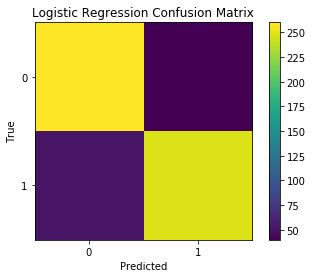

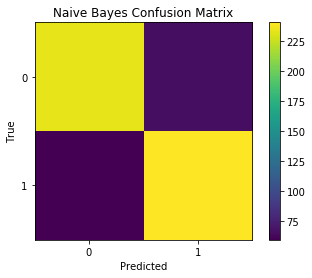

In [160]:
lr_acc, gnb_acc, cfn_matrix_lr, cfn_matrix_gnb = Sentiment_Analysis(train_data['Vectors'], train_data['Label'], \
                                                 test_data['Vectors'], test_data['Label'])

# display logistic regression confusion matrix
print(cfn_matrix_lr)

# display it in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_lr)
plt.colorbar()
plt.title('Logistic Regression Confusion Matrix')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('LR_ConfMatrix')

# display naive bayes confusion matrix
print(cfn_matrix_gnb)

# display it in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_gnb)
plt.colorbar()
plt.title('Naive Bayes Confusion Matrix')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('NB_ConfMatrix')

In [155]:
print("Logistic Regression accuracy is: ", lr_acc)
print("Naive Bayes accuracy is: ", gnb_acc)

Logistic Regression accuracy is:  0.8466666666666667
Naive Bayes accuracy is:  0.7916666666666666


#### (g) N-gram model

In [161]:
def ngram_dict(n, train_data, test_data):
    # create set of unique words in training set
    word_dict = {}

    # iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
    # later when we iterate through both testing and training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                word_dict[words] = 0
    
    # count the number of occurences of each word in dictionary in training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    # count the number of occurences of each word in dictionary in testing set  
    for i in test_data.index:
        word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_testing)):
            if j+n < len(word_tokens_testing):
                words = ' '.join([word_tokens_testing[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    return word_dict

def ngram_feature_vec(n, data, word_dict):
    feature_vecs = []
    for i in data.index:
        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        
        # create a lst of ngrams for this review
        ngram_lst = []
        for j in range(len(word_tokens)):
            if j+n < len(word_tokens):
                ngram_lst.append(' '.join([word_tokens[k] for k in range(j,j+n)]))
        
        feature_vector = np.zeros(len(word_dict.keys())) # to store feature vector of this review
        for k, dict_word in enumerate(word_dict.keys()):
            if dict_word in ngram_lst:
                feature_vector[k] = math.log(word_dict[dict_word] + 1) # apply log normalization
                
        feature_vecs.append(feature_vector) 
    return feature_vecs

In [162]:
# implement the ngram model for n = 2

word_dict = ngram_dict(2, train_data, test_data)

train_data['Vectors_2gram'] = ngram_feature_vec(2, train_data, word_dict)

test_data['Vectors_2gram'] = ngram_feature_vec(2, test_data, word_dict)

In [163]:
lr_acc_2, gnb_acc_2, cfn_matrix_2_lr, cfn_matrix_2_gnb = Sentiment_Analysis(train_data['Vectors_2gram'], train_data['Label'], \
                                                 test_data['Vectors_2gram'], test_data['Label'])

C:\Users\evatr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [164]:
print("Logistic Regression accuracy is: ", lr_acc_2)
print("Naive Bayes accuracy is: ", gnb_acc_2)

Logistic Regression accuracy is:  0.6966666666666667
Naive Bayes accuracy is:  0.6666666666666666


#### PCA

In [165]:
train_matrix = np.matrix((train_data['Vectors']).tolist())
test_matrix = np.matrix((test_data['Vectors']).tolist())

In [166]:
# implement with np.svd
def my_pca(data, dim):
    
    # perform SVD
    U, S, VTrans = sp.linalg.svd(data)
    
    # PCA to keep first 100 dimensions
    U_dim = U[:, :dim]
    S_dim = S[:dim]
    VTrans_dim = VTrans[:dim, :]
        
    S_vT = np.dot(np.diag(S_dim), VTrans_dim)
    train_pca_dim = np.dot(U_dim, S_vT) 
    
    return train_pca_dim

In [167]:
pca_10 = my_pca(train_matrix, 10)

pca_50 = my_pca(train_matrix, 50)

pca_100 = my_pca(train_matrix, 100)

In [168]:
pca_10_test = my_pca(test_matrix, 10)

pca_50_test = my_pca(test_matrix, 50)

pca_100_test = my_pca(test_matrix, 100)

In [169]:
lr_acc_pca10, gnb_acc_pca10, cfn_matrix_pca10_lr, cfn_matrix_pca10_gnb  = Sentiment_Analysis(pca_10, train_data['Label'], pca_10_test, test_data['Label'])

lr_acc_pca50, gnb_acc_pca50, cfn_matrix_pca50_lr, cfn_matrix_pca50_gnb = Sentiment_Analysis(pca_50, train_data['Label'], pca_50_test, test_data['Label'])

lr_acc_pca100, gnb_acc_pca100, cfn_matrix_pca100_lr, cfn_matrix_pca100_gnb = Sentiment_Analysis(pca_100, train_data['Label'], pca_100_test, test_data['Label'])

C:\Users\evatr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\evatr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\evatr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [170]:
print("PCA 10 \n", "Logistic regression accuracy: ", lr_acc_pca10, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca10)
print("PCA 50 \n", "Logistic regression accuracy: ", lr_acc_pca50, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca50)
print("PCA 100 \n", "Logistic regression accuracy: ", lr_acc_pca100, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca100)

PCA 10 
 Logistic regression accuracy:  0.5833333333333334 
 Naive Bayes accuracy:  0.49166666666666664
PCA 50 
 Logistic regression accuracy:  0.6583333333333333 
 Naive Bayes accuracy:  0.55
PCA 100 
 Logistic regression accuracy:  0.6733333333333333 
 Naive Bayes accuracy:  0.5883333333333334


#### (g) Algorithm comparison and analysis

# Clustering for Text Analysis

In [135]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#### (A) Document-wise Clustering

In [136]:
documents = np.load('science2k-doc-word.npy')

In [137]:
documents.shape

(1373, 5476)

In [138]:
sil = []
ks = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(documents)
    labels = kmeans.labels_
    distances = kmeans.inertia_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(documents, labels, metric = 'euclidean'))

    ks.append(k)

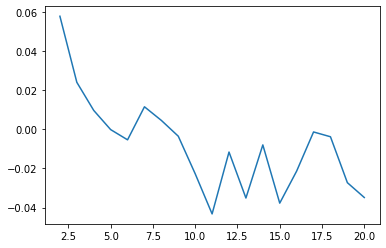

In [139]:
plt.plot(ks, sil)

In [140]:
best_k = ks[np.argmax(sil)]

In [141]:
print(best_k)

2


In [142]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(documents)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
distances = kmeans.inertia_

documents_avg = np.mean(documents,0) 
distances_minus_avg = distances - documents_avg

temp = []
words = []

# for each cluster 
for i in range(best_k):
    
    # go through each label. For each label go through each distances array and select 10 highest positive values
    for j, label in enumerate(labels):
        if(label == i):
            temp.append(distances_minus_avg[j])
            #words.append(labels[j])
            words.append(documents[np.where(labels[j] == i)]) # NEED TO FIX THIS TO RETURN WORD
    
    # sort both lists at the same time
    [x for _,x in sorted(zip(temp,words), reverse = True)]
    
    words_10 = words[10:]
    temp_10 = temp[10:]
    
    # print words for largest 10 distances and distances
    print("Words corresponding to the largest 10 distances in cluster: ", i, ": \n")
    
    for i in range(10):
        print("Word: ", words_10[i+1], " Distance: ", temp_10[i+1], "\n")

#### IN PROGRESS ######

Words corresponding to the largest 10 distances in cluster:  0 : 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779056.86806984 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779059.779566556 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779058.89030025 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779057.50582595 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779058.43489391 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779057.5268252 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779058.25346439 

Word:  [[-0.2521619 -0.2521619  9.36371   ... -0.2521619 -0.2521619 -0.2521619]]  Distance:  33779057.160728976 

Word:  [[-0.2521619 -0.25216

#### (B) Term-wise Clustering

In [ ]:
words = np.load('science2k-word-doc.npy')

In [ ]:
words.shape

In [ ]:
sil = []
ks = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(words)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(words, labels, metric = 'euclidean'))

    ks.append(k)

In [ ]:
plt.plot(ks, sil)

In [ ]:
best_k = ks[np.argmax(sil)]

In [ ]:
print(best_k)

In [ ]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(words)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
    
#### IN PROGRESS ######

# EM Algorithm and Implementation

a)

b)

In [100]:
# import libraries
from sklearn import mixture 

dataList = []

with open('faithful.dat.txt') as f:
    df = pd.DataFrame()
    data = False
    for line in f:
        if data == True:
            line = (line.strip()).split()
            line.pop(0) # to remove index (we can comment this line and add it back if needed)
            dataList.append(line)
        if line == '    eruptions waiting\n':
                data = True

df = pd.DataFrame(dataList)
df.columns = ['eruptions', 'waiting']

In [87]:
df # quality check

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
5,2.883,55
6,4.700,88
7,3.600,85
8,1.950,51
9,4.350,85


Text(0, 0.5, 'Waiting')

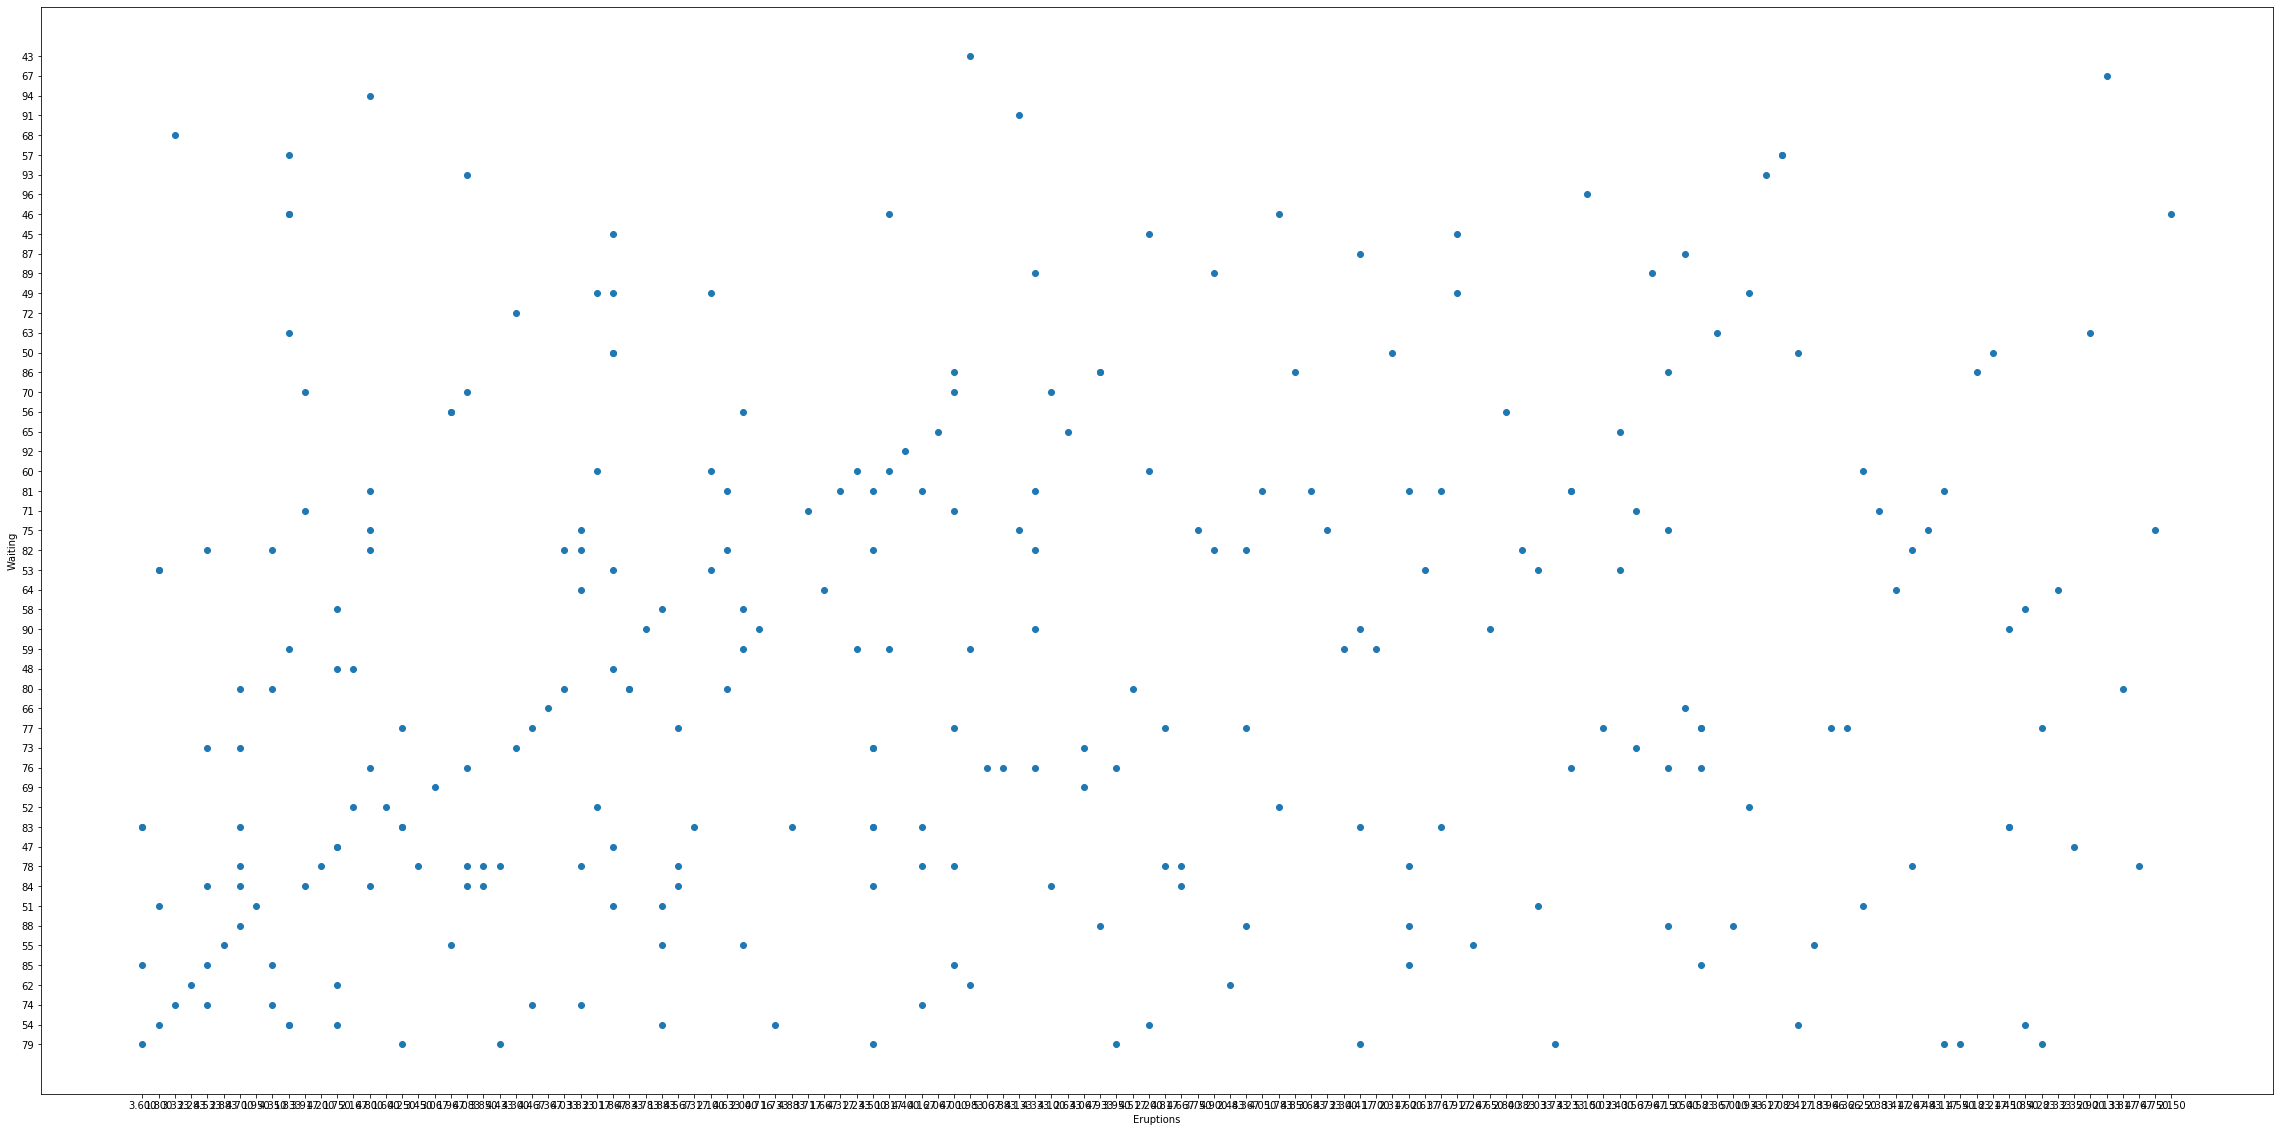

In [97]:
# plot dataframe
plt.figure(figsize=(40,20))
plt.scatter(df['eruptions'], df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

c)

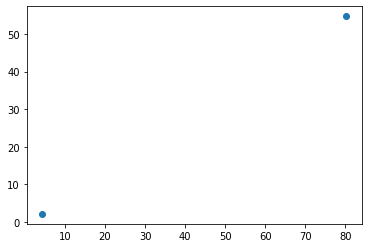

In [134]:
g = mixture.GaussianMixture(n_components=2, covariance_type = 'spherical', max_iter = 100)
g.fit(df)
iterations = list(range(100))

plt.scatter(g.means_[:][0], g.means_[:][1])
plt.show() # how to incorporate n iterations to plot? because then it becomes 3d and it says 2d...

# Multidimensional scaling for genetic population differences

In [173]:
# import libraries
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
#from pyclustering.cluster.kmedoids import kmedoids # PYTHON CANT FIND THIS :(
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import pylab as pl
data = np.load("mds-population.npz")
print (data['D']) # Distance matrix
print (data['population_list']) # List of populations

# WILL REMOVE THIS BECAUSE THE B IS NOT PART OF THE STRING IT JUST COMES OUT WHEN YOU PRINT 
# since there is a 'b' character before every ethnicity, remove it and clean the data
#for i, element in enumerate (data['population_list']):
    #print(element)
    #element_clean = element[1:]
    #print(element_clean)
    #(data['population_list'])[i] = element_clean

# print clean data
#print (data['population_list']) 

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


a) Perform MDS and analyze the results

i) 

In this case we are using metric MDS. Metric MDS assumes that the data can be represented by vectors 
along the set of dimensions indicated and that the relationship between the distance and the dissimilarity
is inversely proportional. It also assumes the data lives in a low-dimensional manifold. - NOT SURE ABOUT THE MANIDOLF ONE NEED TO CHECK

This could cause problems for the situation where the data is clumpy instead of manifoldy. It could also
cause problems if, for instance, the principal directions of variation for a dataset are the first 3 dimensions, but we choose to only consider the first 2 dimensions for MDS.

One way to measure how much information is being lost would be to apply MDS for the largest number of dimensions that we are willing to consider, then perform SVD on the resulting data to find the dimensions of greatest variation. Based on this we can optimize the number of dimensions that best represents the data and apply MDS again using this.

ii)

For this part, we decided to perform MDS for a high number of dimensions and check the eigenvalues of the result 
by performing SVD. Looking at the singular values in S (covariance matrix) obtained from SVD, we decided to consider the first 5 dimensions as the ones which give an accurate low-dimensional representation of the data because they were powers of 100. The rest of singular values were powers of 10 and 1. We then used this finding to apply MDS with 5 dimensions.

In [174]:
# apply 20 dimensional MDS
embedding = MDS(n_components=20, dissimilarity = 'precomputed')
out_MDS_20 = embedding.fit_transform(data['D'])

# perform svd on the result
U_out, S_out, VTrans_out = sp.linalg.svd(out_MDS_20)

print(S_out) # found first 5 dimensions to be most significant

# apply 5 dimensional MDS
embedding = MDS(n_components=5, dissimilarity = 'precomputed')
out_MDS_5 = embedding.fit_transform(data['D'])

[7.17996342e+02 4.50094093e+02 3.72322380e+02 2.24184681e+02
 1.35057972e+02 8.51266365e+01 7.28365666e+01 6.22395313e+01
 2.50272772e+01 1.41174128e+01 8.65993611e+00 7.70120593e+00
 2.00548250e+00 1.45532619e+00 6.69937279e-01 5.37546169e-01
 1.34947362e-01 5.97723504e-02 5.11816112e-02 1.97025504e-02]


iii)

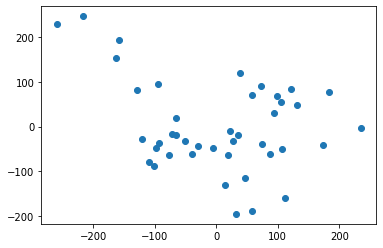

In [176]:
# apply 2 dimensional MDS
embedding = MDS(n_components=2, dissimilarity = 'precomputed')
out_MDS = embedding.fit_transform(data['D'])

# display results
plt.scatter(out_MDS[:, 0], out_MDS[:, 1])
plt.savefig('MDS')

b) k-means on 2d embedding

4


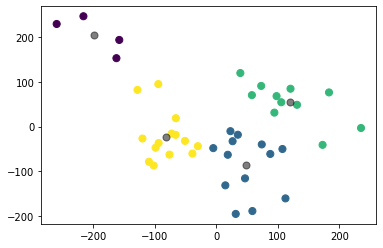

In [179]:
# find the best k

sil = []
ks = []

for k in range(2, 5):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(out_MDS)
    labels = kmeans.labels_
    distances = kmeans.inertia_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(out_MDS, labels, metric = 'euclidean'))

    ks.append(k)
    
best_k = ks[np.argmax(sil)]

print(best_k)

# run k-means on data with best k 

kmeans_best = KMeans(n_clusters = best_k, max_iter = 10000).fit(out_MDS)
kmeans_best.fit(out_MDS)
y_kmeans = kmeans_best.predict(out_MDS)
centers = kmeans_best.cluster_centers_

plt.scatter(out_MDS[:, 0], out_MDS[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5)
plt.savefig('kmeans_4')

We don't fully agree with the clustering results because it also looks like there could be 3 clusters, or even 4. The information about what features the distance is being calculated on is vital for understanding and representing the data, as well as for figuring out if the clusters make sense.

c) Comparing hierarchical clustering with k-means

C:\Users\evatr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


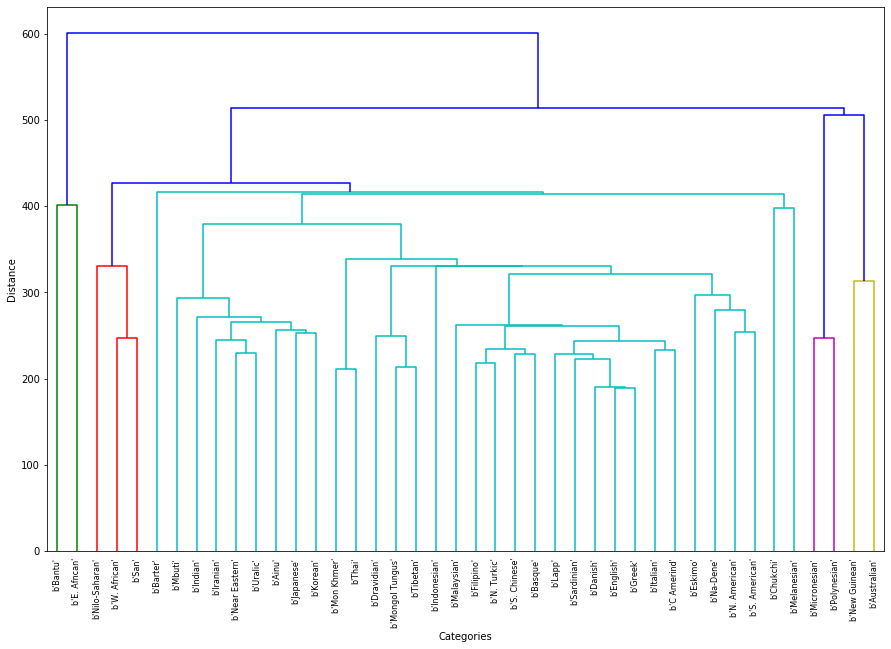

In [180]:
Z = linkage(data['D'])
plt.figure(figsize=(15,10))
dn = dendrogram(Z, no_plot = True)
labels = data['population_list']
lenght = len(labels)

# create a dictionary for the labels
temp = {dn["leaves"][ii]: labels[ii] for ii in range(len(dn["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

# dendogram with the labels we want
dn = dendrogram(Z, leaf_label_func=llf)

plt.xlabel('Categories')
plt.ylabel('Distance')
plt.savefig('hierarchy')

In [181]:
# turn resulting tree into flat clustering of points
flat_clusters = fcluster(Z, t=601.38, criterion='distance') # using a threshold of 601.38 for the distance we get two clusters (k=2) 
# and most of the points assigned to the second cluster, like in k-means above

print(flat_clusters)

[1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]


Colors Array Shape:  (42,)


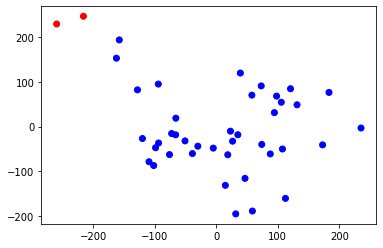

In [182]:
# plot results
colors = [] # to store colour of each point to in the scatterplot

# display results
for i, element in enumerate(flat_clusters):
    if(element == 1):
        colors.append("red")
    else:
        colors.append("blue")

colors_array = np.asarray(colors)

# check it is the right size and the code is working properly
print("Colors Array Shape: ", colors_array.shape)

# display results
plt.scatter(out_MDS[:, 0], out_MDS[:, 1], c=colors)
plt.savefig('flat_clusters')

Compared to the k-means clustering computer earlier, this technique groups more points into the second cluster. The first cluster in this case only contains 2 points. The k-means clustering results look more realistic and efficient.

d) k-medoids comparison with k-means

In [35]:
# apply k-medoids clustering to data
init_medoids = [1, 500]

# Create instance of k-medoids
kmedoids = kmedoids(out_MDS, initial_medoids)

# obtain k-medoids results
kmedoids.process()

clusters = kmedoids.get_clusters()

NameError: name 'kmedoids' is not defined